In [18]:
import pandas as pd
import os
import datetime

path = "./file_csv/flight/"
os.chdir(path)

# 데이터 병합
list_flight = ['flight_data_08', 'flight_data_09', 'flight_data_10']

data = {}
for i in list_flight:
    data[i] = pd.read_csv(f'{i}.csv')
all_data = pd.concat(data.values(), ignore_index=True)

def flight_EDA(file):

    # 결측치 및 중복값 삭제
    df = file.dropna()
    df = df.drop_duplicates()

    # 요일 컬럼 생성
    df['date'] = pd.to_datetime(df['date'])
    dateDict = {0:"월요일", 1:"화요일", 2:"수요일", 3:"목요일", 4:"금요일", 5:"토요일", 6:"일요일"}   

    def day_output(date):
        return dateDict[date.weekday()]
    
    df['day'] = df['date'].apply(day_output)

    # 주말 / 공휴일 컬럼 생성
    holiday_list = ['2023-08-15', '2023-09-28', '2023-09-29', '2023-09-30', '2023-10-03', '2023-10-09']
    weekends_list = ['금요일', '토요일', '일요일']

    def day_off(row):
        date = pd.to_datetime(row['date']).strftime('%Y-%m-%d')  # 날짜 형식을 통일하기 위해 문자열로 변환
        if date in holiday_list:
            return '공휴일'
        elif row['day'] in weekends_list:
            return '주말'
        else:
            return '평일'

    df['holiday'] = df.apply(day_off, axis=1)

    # 특가석 병합
    def seat_merge(seat):
        if (seat == '특가석-환불불가') or (seat == '특가석-수하물유료'):
            return '특가석'
        else:
            return seat
    df['seat'] = df['seat'].apply(seat_merge)

    # 하이에어 제거 (8월 데이터만 존재 >> 이상치로 간주)
    df = df.drop(df[(df['airline'] == '하이에어')].index)

    # df csv 파일로 저장
    df.to_csv("all_flight_EDA.csv", index=False, encoding="utf-8-sig", mode="w")

    return df

df = flight_EDA(all_data)
print(df)

      airline       date departure_time arrival_time departure_place  \
0        대한항공 2023-08-01          16:40        17:40             PUS   
1        제주항공 2023-08-01          17:05        18:00             PUS   
2        에어부산 2023-08-01          17:30        18:30             PUS   
3        에어부산 2023-08-01          18:00        19:00             PUS   
4         진에어 2023-08-01          19:00        20:00             PUS   
...       ...        ...            ...          ...             ...   
43691    제주항공 2023-10-31          08:45        09:55             CJU   
43692   티웨이항공 2023-10-31          08:45        09:55             CJU   
43693    제주항공 2023-10-31          08:45        09:55             CJU   
43694  아시아나항공 2023-10-31          09:00        10:10             CJU   
43695  아시아나항공 2023-10-31          09:00        10:10             CJU   

      arrival_place  flight_time seat   price  day holiday  
0               CJU           60  일반석  102700  화요일      평일  
1            

In [19]:
holi = df['holiday'].unique()
print(holi)

['평일' '주말' '공휴일']


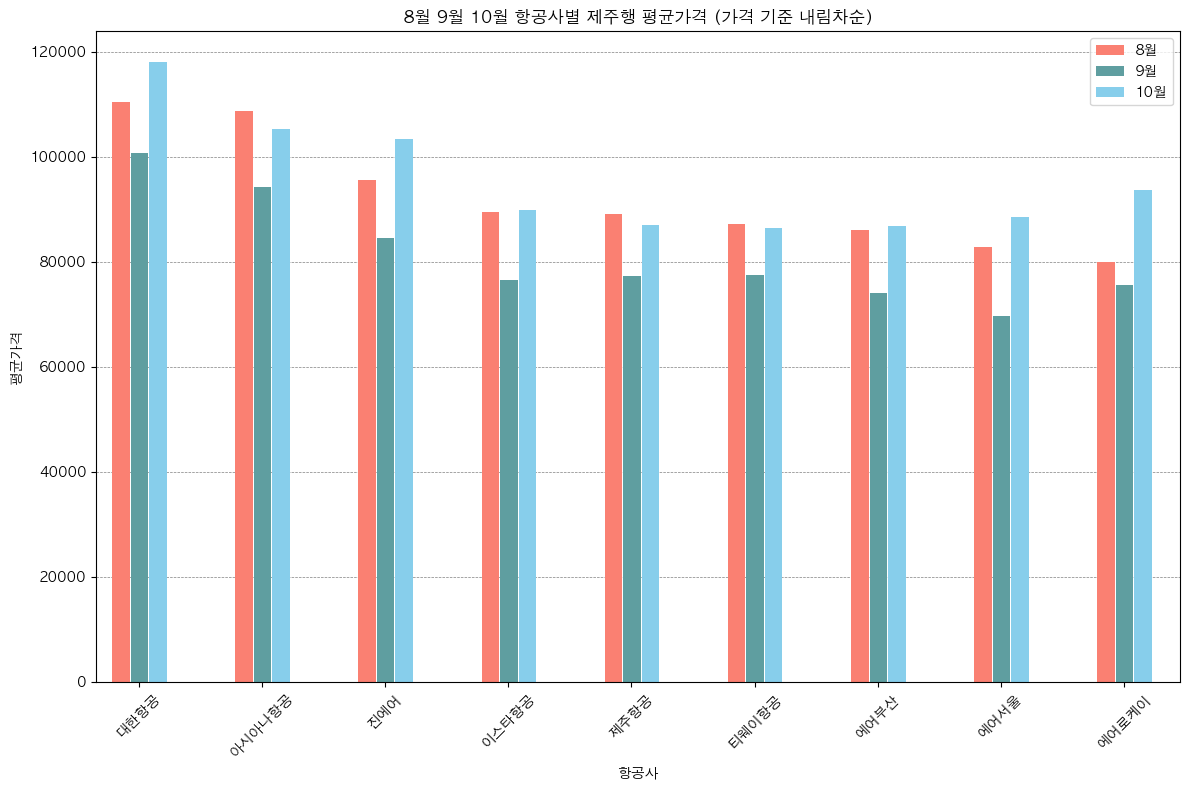

In [2]:
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
import os
#상위 다이렉트로 가기
os.chdir('../..')
directory = './EDA'
if not os.path.exists(directory):
    os.makedirs(directory)
#제주행 df
df_cju = df[df['arrival_place'] == 'CJU']

#offset으로 바 간격 주기
def compute_pos(index, width, i, n, offset=0.2):
    correction = i - 0.5 * (n - 1)
    return index + width * correction + offset


# 한글깨짐 설정
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

# datetime으로 변경
df_cju.loc[:, 'date'] = pd.to_datetime(df_cju['date'])

# 8월, 9월, 10월 추출
august = df_cju[df_cju['date'].dt.month == 8]
september = df_cju[df_cju['date'].dt.month == 9]
october = df_cju[df_cju['date'].dt.month == 10]

# 항공사별 월 마다 가격 평균
aug_avg = august.groupby('airline')['price'].mean()
sep_avg = september.groupby('airline')['price'].mean()
oct_avg = october.groupby('airline')['price'].mean()

# 인덱스 설정
all_airlines = set(aug_avg.index) | set(sep_avg.index) | set(oct_avg.index)
index = np.arange(len(all_airlines))

# 내림차순
sorted_index = aug_avg.reindex(all_airlines).sort_values(ascending=False).index

# 컬러 설정
colors = ['salmon', 'cadetblue', 'skyblue']

# 그래프 설정
bar_width = 0.15  # Custom bar width

# 시각화
fig, ax = plt.subplots(figsize=(12, 8))

aug_bar = ax.bar(compute_pos(index, bar_width, 0, 3, offset=0.2), aug_avg.reindex(sorted_index).values,
                 bar_width * 0.95, label='8월', color=colors[0])
sep_bar = ax.bar(compute_pos(index, bar_width, 1, 3, offset=0.2), sep_avg.reindex(sorted_index).values,
                 bar_width * 0.95, label='9월', color=colors[1])
oct_bar = ax.bar(compute_pos(index, bar_width, 2, 3, offset=0.2), oct_avg.reindex(sorted_index).values,
                 bar_width * 0.95, label='10월', color=colors[2])

#바 차트끼리 조금 띄기
ax.set_xlim(-bar_width, len(index) - 1 + bar_width * 3 + 0.2)

ax.set_xlabel('항공사')
ax.set_ylabel('평균가격')
ax.set_title('8월 9월 10월 항공사별 제주행 평균가격 (가격 기준 내림차순)')

#x축 옮기기
ax.set_xticks(index + 1.3 * bar_width)
#x축 라벨 회전
ax.set_xticklabels(sorted_index, rotation=45)
ax.legend()

# 보조선(눈금선) 나타내기
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='gray', linestyle='dashed', linewidth=0.5)

# 그래프 저장하고 출력하기
plt.tight_layout()
plt.savefig('./EDA/항공사별_제주행_평균가격.png', format='png', dpi=300)
plt.show()

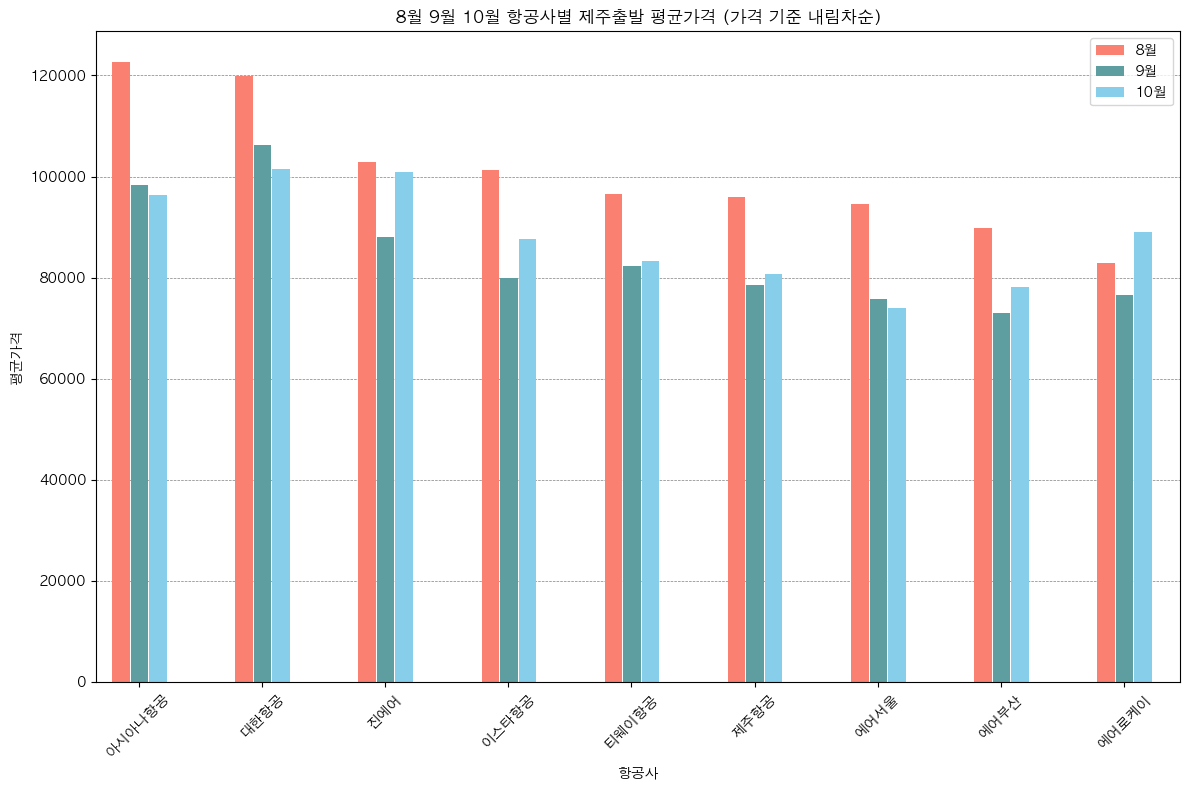

In [3]:
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np

directory = './EDA'
if not os.path.exists(directory):
    os.makedirs(directory)
#제주행 출발행
df_cju_d = df[df['departure_place'] == 'CJU']

#offset으로 바 간격 주기
def compute_pos(index, width, i, n, offset=0.2):
    correction = i - 0.5 * (n - 1)
    return index + width * correction + offset


# 한글깨짐 설정
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

# datetime으로 변경
df_cju_d.loc[:, 'date'] = pd.to_datetime(df_cju_d['date'])

# 8월, 9월, 10월 추출
august = df_cju_d[df_cju_d['date'].dt.month == 8]
september = df_cju_d[df_cju_d['date'].dt.month == 9]
october = df_cju_d[df_cju_d['date'].dt.month == 10]

# 항공사별 월 마다 가격 평균
aug_avg = august.groupby('airline')['price'].mean()
sep_avg = september.groupby('airline')['price'].mean()
oct_avg = october.groupby('airline')['price'].mean()

# 인덱스 설정
all_airlines = set(aug_avg.index) | set(sep_avg.index) | set(oct_avg.index)
index = np.arange(len(all_airlines))

# 내림차순
sorted_index = aug_avg.reindex(all_airlines).sort_values(ascending=False).index

# 컬러 설정
colors = ['salmon', 'cadetblue', 'skyblue']

# 그래프 설정
bar_width = 0.15  # Custom bar width

# 시각화
fig, ax = plt.subplots(figsize=(12, 8))

aug_bar = ax.bar(compute_pos(index, bar_width, 0, 3, offset=0.2), aug_avg.reindex(sorted_index).values,
                 bar_width * 0.95, label='8월', color=colors[0])
sep_bar = ax.bar(compute_pos(index, bar_width, 1, 3, offset=0.2), sep_avg.reindex(sorted_index).values,
                 bar_width * 0.95, label='9월', color=colors[1])
oct_bar = ax.bar(compute_pos(index, bar_width, 2, 3, offset=0.2), oct_avg.reindex(sorted_index).values,
                 bar_width * 0.95, label='10월', color=colors[2])

#바 차트끼리 조금 띄기
ax.set_xlim(-bar_width, len(index) - 1 + bar_width * 3 + 0.2)

ax.set_xlabel('항공사')
ax.set_ylabel('평균가격')
ax.set_title('8월 9월 10월 항공사별 제주출발 평균가격 (가격 기준 내림차순)')

#x축 옮기기
ax.set_xticks(index + 1.3 * bar_width)
#x축 라벨 회전
ax.set_xticklabels(sorted_index, rotation=45)
ax.legend()

# 보조선(눈금선) 나타내기
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='gray', linestyle='dashed', linewidth=0.5)

# 그래프 저장하고 출력하기
plt.tight_layout()
plt.savefig('./EDA/항공사별_제주출발_평균가격.png', format='png', dpi=300)
plt.show()

/var/folders/5x/8_5m_9v57bz_btfk508ff3hc0000gn/T/ipykernel_74367/2379704051.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Blues', len(airline_counts))


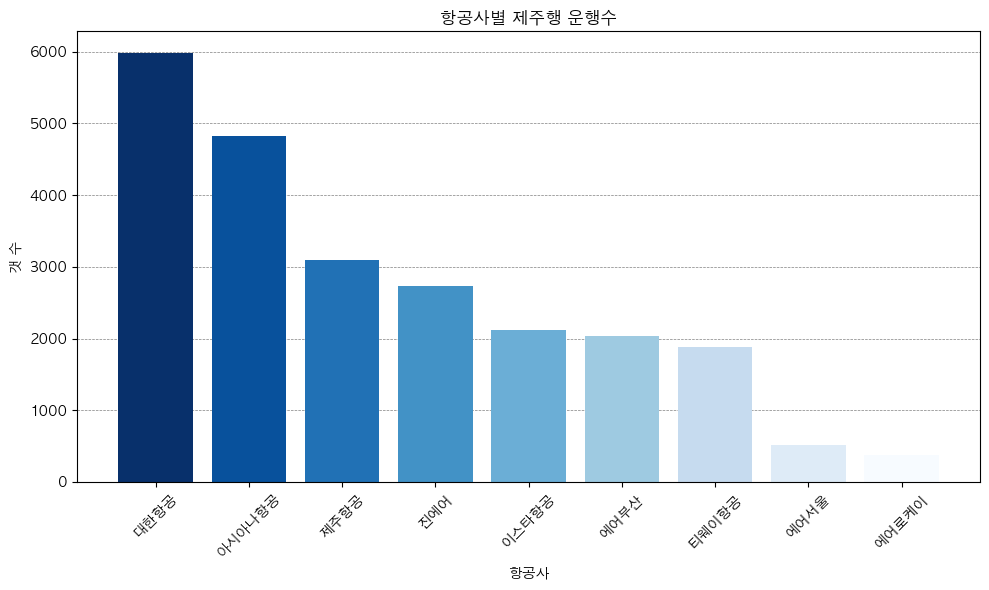

In [4]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

directory = './EDA'
if not os.path.exists(directory):
    os.makedirs(directory)
# 항공사별 카운트
airline_counts = df_cju['airline'].value_counts()

# 바 그래프 시각화
fig, ax = plt.subplots(figsize=(10, 6))

# 바 그래프 생성 - 색상을 skyblue로 지정하고 오른쪽으로 갈수록 색이 연해지도록 컬러맵 설정
colors = plt.cm.get_cmap('Blues', len(airline_counts))
ax.bar(airline_counts.index, airline_counts.values, color=colors(range(len(airline_counts))[::-1]))

# x축 라벨 및 타이틀 설정
ax.set_xlabel('항공사')
ax.set_ylabel('갯 수')
ax.set_title('항공사별 제주행 운행수')

# x축 라벨 회전
plt.xticks(rotation=45)

# 보조선(눈금선) 나타내기
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='gray', linestyle='dashed', linewidth=0.5)

plt.tight_layout()
plt.savefig('./EDA/항공사별_제주행_운행수.png', format='png', dpi=300)
plt.show()

/var/folders/5x/8_5m_9v57bz_btfk508ff3hc0000gn/T/ipykernel_74367/392125116.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Blues', len(airline_counts))


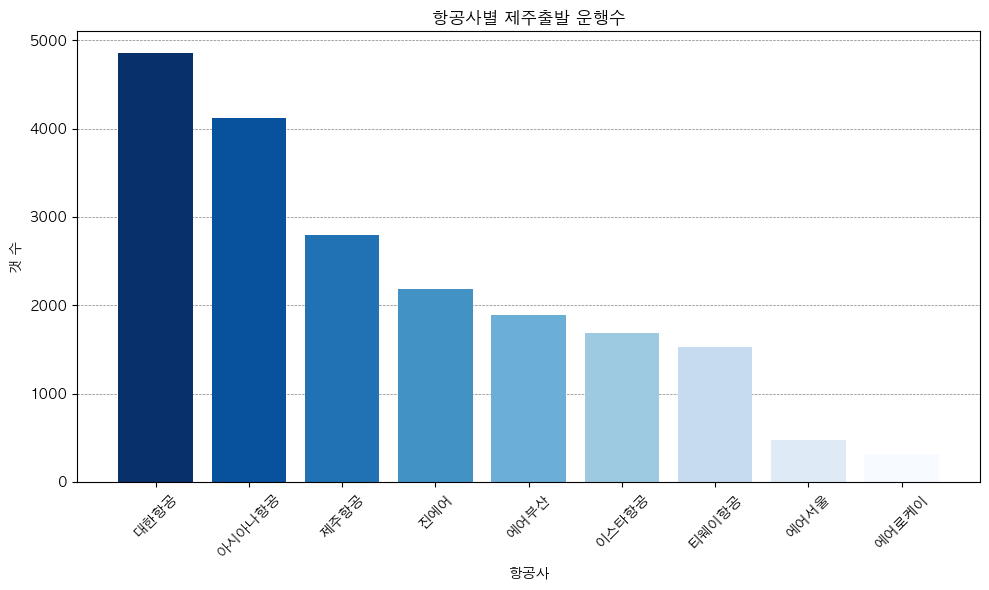

In [5]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# 항공사별 카운트
airline_counts = df_cju_d['airline'].value_counts()

# 바 그래프 시각화
fig, ax = plt.subplots(figsize=(10, 6))

# 바 그래프 생성 - 색상을 skyblue로 지정하고 오른쪽으로 갈수록 색이 연해지도록 컬러맵 설정
colors = plt.cm.get_cmap('Blues', len(airline_counts))
ax.bar(airline_counts.index, airline_counts.values, color=colors(range(len(airline_counts))[::-1]))

# x축 라벨 및 타이틀 설정
ax.set_xlabel('항공사')
ax.set_ylabel('갯 수')
ax.set_title('항공사별 제주출발 운행수')

# x축 라벨 회전
plt.xticks(rotation=45)

# 보조선(눈금선) 나타내기
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='gray', linestyle='dashed', linewidth=0.5)

plt.tight_layout()
plt.savefig('./EDA/항공사별_제주출발_운행수.png', format='png', dpi=300)
plt.show()